In [72]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from keras.models import Sequential
import matplotlib.patches as mpatches
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from google.colab import files

import os


In [73]:
uploaded=files.upload()
temperature=pd.read_csv("Temperature.csv",parse_dates= {"date" : ["year","month","day"]},
                keep_date_col=True)
#convert the temperature from object to int 64/float
temperature.max_temp = pd.to_numeric(temperature.max_temp, errors='coerce')
temperature.min_temp = pd.to_numeric(temperature.min_temp, errors='coerce')
temperature.mean_temp = pd.to_numeric(temperature.mean_temp, errors='coerce')

#remove the row which has NaN value
temperature=temperature.dropna()
temperature.head(10)

temp_max_data = temperature[["date","max_temp"]]
temp_min_data = temperature[["date","min_temp"]]
temp_mean_data = temperature[["date","mean_temp"]]

temp_max_data["date"] = pd.to_datetime(temp_max_data['date'], infer_datetime_format=True)
temp_max_data = temp_max_data.set_index(["date"])
temp_min_data["date"] = pd.to_datetime(temp_min_data['date'], infer_datetime_format=True)
temp_min_data = temp_min_data.set_index(["date"])
temp_mean_data["date"] = pd.to_datetime(temp_mean_data['date'], infer_datetime_format=True)
temp_mean_data = temp_mean_data.set_index(["date"])


Saving Temperature.csv to Temperature (1).csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [74]:
temp_max_data  =temp_max_data.resample('D').mean()

In [75]:
temp_min_data  =temp_min_data.resample('D').mean()

In [76]:
temp_mean_data  =temp_mean_data.resample('D').mean()

In [77]:
temp_max_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5752 entries, 2007-01-01 to 2022-09-30
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   max_temp  5736 non-null   float64
dtypes: float64(1)
memory usage: 89.9 KB


In [78]:
temp_min_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5752 entries, 2007-01-01 to 2022-09-30
Freq: D
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   min_temp  5736 non-null   float64
dtypes: float64(1)
memory usage: 89.9 KB


In [79]:
temp_mean_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5752 entries, 2007-01-01 to 2022-09-30
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mean_temp  5736 non-null   float64
dtypes: float64(1)
memory usage: 89.9 KB


In [80]:
from scipy.interpolate import interp1d

In [81]:
temp_max_data['max_temp'] = temp_max_data['max_temp'].interpolate()# we will fill the null row

In [82]:
temp_min_data['min_temp'] = temp_min_data['min_temp'].interpolate()# we will fill the null row

In [83]:
temp_mean_data['mean_temp'] = temp_mean_data['mean_temp'].interpolate()# we will fill the null row

In [84]:
temp_max_df = temp_max_data.copy()
temp_min_df = temp_min_data.copy()
temp_mean_df = temp_mean_data.copy()

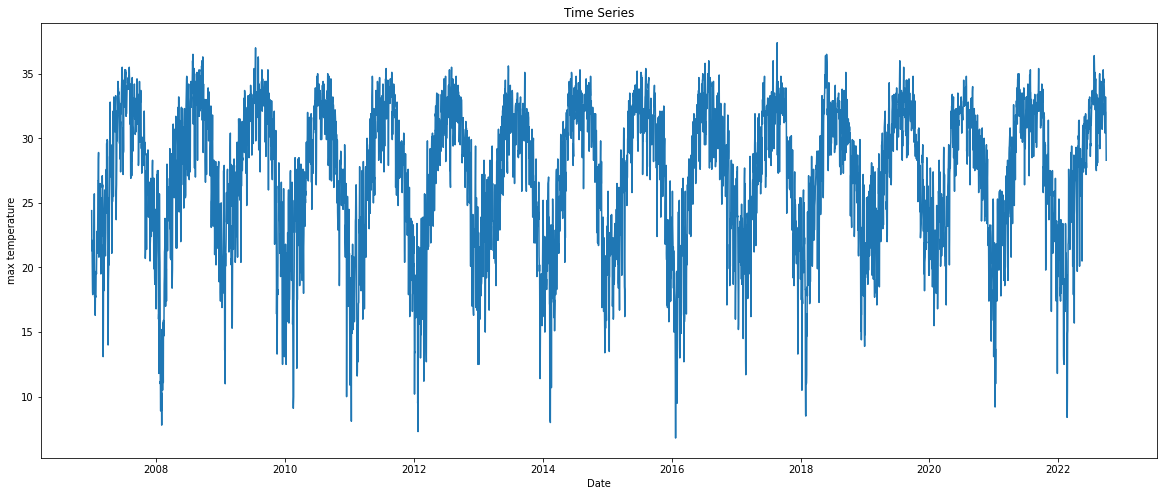

In [85]:
plt.figure(figsize=(20,8))
plt.plot(temp_max_data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('max temperature')
plt.show()

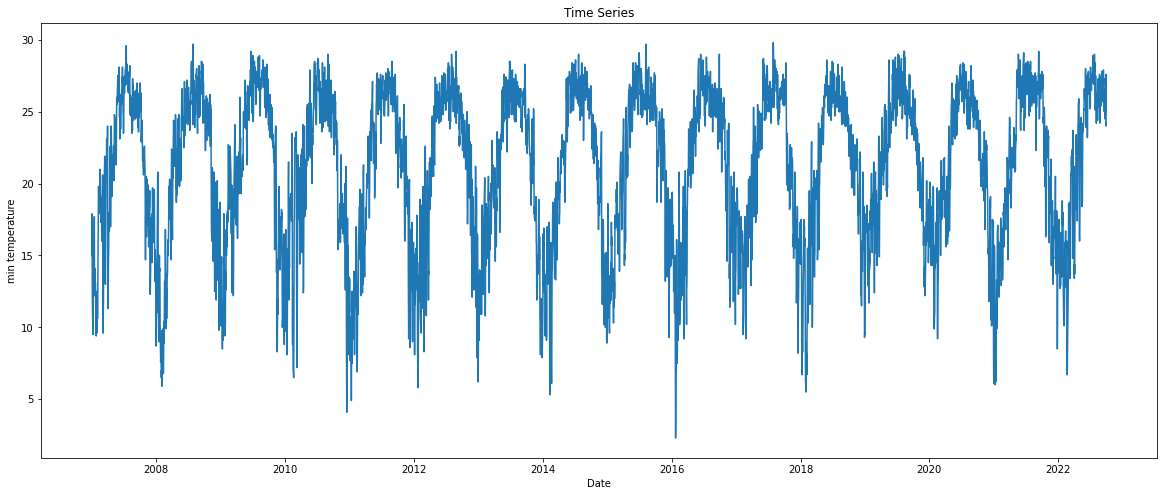

In [86]:
plt.figure(figsize=(20,8))
plt.plot(temp_min_data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('min temperature')
plt.show()

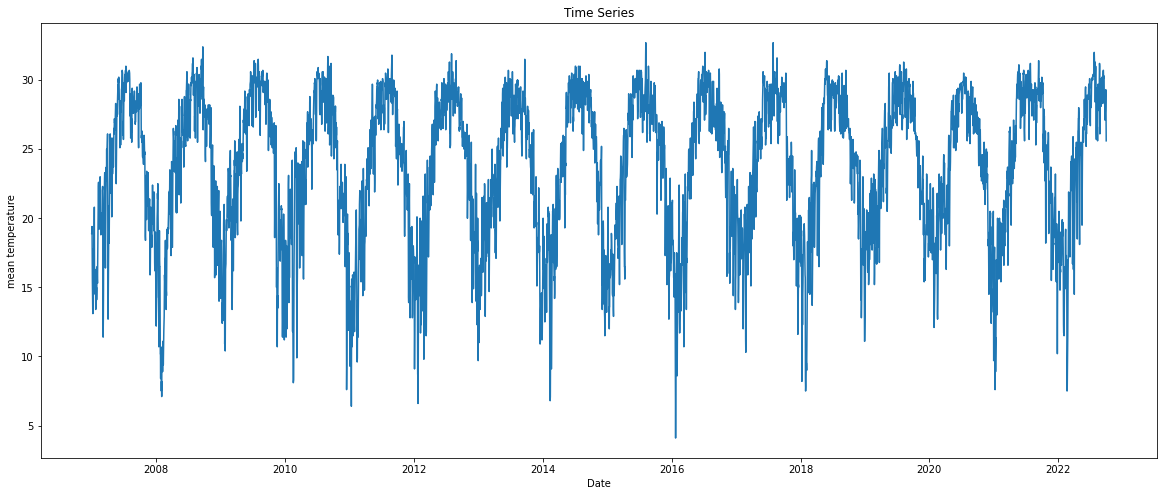

In [87]:
plt.figure(figsize=(20,8))
plt.plot(temp_mean_data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('mean temperature')
plt.show()

In [88]:
temp_max_data = temp_max_data.values
temp_max_data = temp_max_data.astype('float32')

In [89]:
scaler= MinMaxScaler(feature_range=(-1,1))
max_sc = scaler.fit_transform(temp_max_data)


In [90]:
max_sc

array([[ 0.15032673],
       [-0.0522877 ],
       [ 0.        ],
       ...,
       [ 0.6470587 ],
       [ 0.496732  ],
       [ 0.4052286 ]], dtype=float32)

In [91]:
timestep = 90

X= []
Y=[]


for i in range(len(max_sc)- (timestep)):
    X.append(max_sc[i:i+timestep])
    Y.append(max_sc[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 5602
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]    
Ytrain = Y[:k]    
Ytest= Y[k:]   

In [92]:
print(Xtrain.shape)
print(Xtest.shape)

(5602, 90, 1)
(60, 90, 1)


In [93]:
model = Sequential()

model.add(LSTM(32,activation = 'relu', input_shape= (90,1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [94]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 90, 32)            4352      
                                                                 
 lstm_7 (LSTM)               (None, 90, 32)            8320      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [95]:
history = model.fit(Xtrain,Ytrain,epochs=50, verbose=1)

Epoch 1/50
176/176 [==============================] - 21s 99ms/step - loss: 0.0548
Epoch 2/50
176/176 [==============================] - 17s 98ms/step - loss: 0.0374
Epoch 3/50
176/176 [==============================] - 18s 105ms/step - loss: 0.0341
Epoch 4/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0340
Epoch 5/50
176/176 [==============================] - 17s 96ms/step - loss: 0.0324
Epoch 6/50
176/176 [==============================] - 17s 96ms/step - loss: 0.0295
Epoch 7/50
176/176 [==============================] - 17s 98ms/step - loss: 0.0256
Epoch 8/50
176/176 [==============================] - 18s 104ms/step - loss: 0.0233
Epoch 9/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0217
Epoch 10/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0218
Epoch 11/50
176/176 [==============================] - 17s 98ms/step - loss: 0.0213
Epoch 12/50
176/176 [==============================] - 17s 98ms/step - loss: 0.0216

Text(0.5, 1.0, 'Model Accuracy')

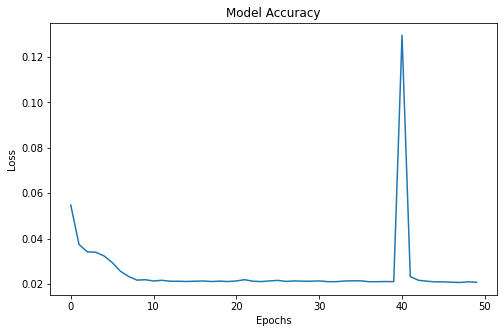

In [96]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [97]:
preds= model.predict(Xtest)
preds = scaler.inverse_transform(preds)


Ytest=np.asanyarray(Ytest)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(Ytest)


Ytrain=np.asanyarray(Ytrain)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(Ytrain)

mean_squared_error(Ytest,preds)

2/2 [==============================] - 0s 26ms/step


2.7431576

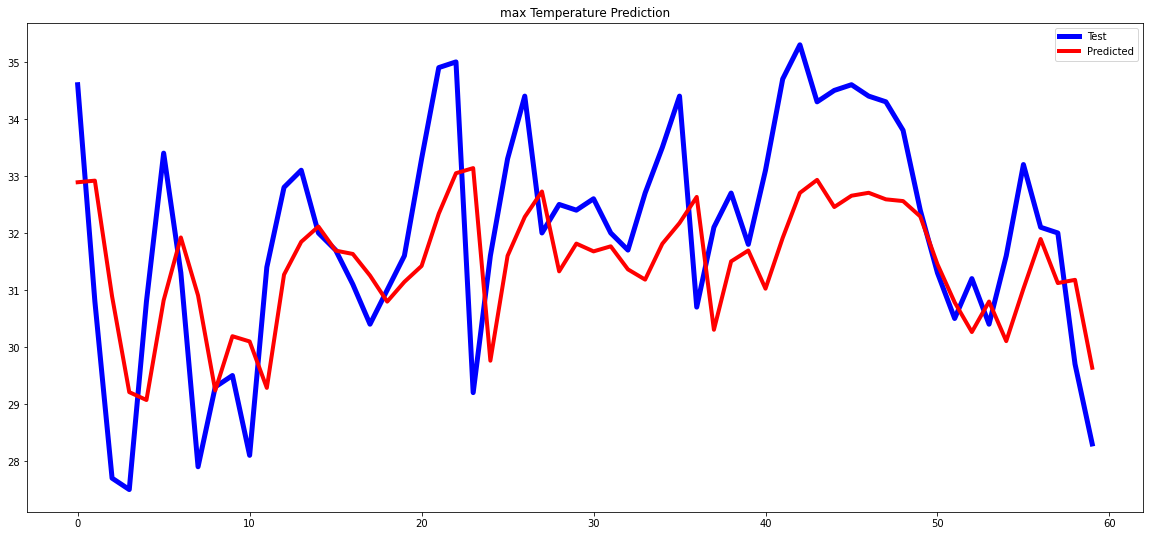

In [98]:
plt.figure(figsize=(20,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("max Temperature Prediction")
plt.show()


In [99]:
test = pd.DataFrame(Ytest,columns=['Actual'])
pred = pd.DataFrame(preds,columns=['Predict'])

In [100]:
results = pd.concat([test,pred],axis=1)

In [101]:
results.head(9)

,Actual,Predict
0,34.599998,32.889336
1,30.799999,32.917622
2,27.700001,30.889181
3,27.500000,29.208513
4,30.799999,29.070610
5,33.400002,30.818903
6,31.300001,31.921310
7,27.900000,30.903864
8,29.299999,29.237671


In [102]:
def insert_end(Xin,new_input):
    #print ('Before: \n', Xin , new_input )
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    #print ('After :\n', Xin)
    return Xin


In [103]:
temp_max_df

,max_temp
date,
2007-01-01,24.4
2007-01-02,21.3
2007-01-03,22.1
2007-01-04,20.8
2007-01-05,19.8
...,...
2022-09-26,33.2
2022-09-27,32.1
2022-09-28,32.0


In [104]:
# this section for unknown future
#we are getting next 30 steps
from datetime import timedelta
future=60
forcast = []
Xin = Xtest[-1:,:,:]
time=[]
for i in range(future):
    out = model.predict(Xin, batch_size=1)    
    forcast.append(out[0,0]) 
    print(forcast)
    Xin = insert_end(Xin,out[0,0]) 
    time.append(pd.to_datetime(temp_max_df.index[-1])+timedelta(days=i+1))

1/1 [==============================] - 0s 27ms/step
[0.49259356]
1/1 [==============================] - 0s 25ms/step
[0.49259356, 0.49772865]
1/1 [==============================] - 0s 29ms/step
[0.49259356, 0.49772865, 0.4977061]
1/1 [==============================] - 0s 29ms/step
[0.49259356, 0.49772865, 0.4977061, 0.49364752]
1/1 [==============================] - 0s 29ms/step
[0.49259356, 0.49772865, 0.4977061, 0.49364752, 0.49110532]
1/1 [==============================] - 0s 26ms/step
[0.49259356, 0.49772865, 0.4977061, 0.49364752, 0.49110532, 0.49142346]
1/1 [==============================] - 0s 25ms/step
[0.49259356, 0.49772865, 0.4977061, 0.49364752, 0.49110532, 0.49142346, 0.49367383]
1/1 [==============================] - 0s 28ms/step
[0.49259356, 0.49772865, 0.4977061, 0.49364752, 0.49110532, 0.49142346, 0.49367383, 0.4957749]
1/1 [==============================] - 0s 30ms/step
[0.49259356, 0.49772865, 0.4977061, 0.49364752, 0.49110532, 0.49142346, 0.49367383, 0.4957749, 0.49

In [105]:
forcasted_output=np.asanyarray(forcast)   
forcasted_output=forcasted_output.reshape(-1,1) 
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [106]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output],axis=1)
df_result.columns = "Date","Forecasted"

In [107]:
df_result

,Date,Forecasted
0,2022-10-01,29.636683
1,2022-10-02,29.715248
2,2022-10-03,29.714905
3,2022-10-04,29.652809
4,2022-10-05,29.613913
5,2022-10-06,29.618780
6,2022-10-07,29.653210
7,2022-10-08,29.685356
8,2022-10-09,29.706593
9,2022-10-10,29.729267


In [108]:
temp_min_data = temp_min_data.values
temp_min_data = temp_min_data.astype('float32')

In [109]:
scaler= MinMaxScaler(feature_range=(-1,1))
min_sc = scaler.fit_transform(temp_min_data)
min_sc

array([[-0.07636368],
       [ 0.07636368],
       [ 0.13454545],
       ...,
       [ 0.84000003],
       [ 0.57818186],
       [ 0.5999999 ]], dtype=float32)

In [125]:
timestep = 90

X_min= []
Y_min=[]


for i in range(len(min_sc)- (timestep)):
    X_min.append(min_sc[i:i+timestep])
    Y_min.append(min_sc[i+timestep])


X_min=np.asanyarray(X_min)
Y_min=np.asanyarray(Y_min)


k = 5602
X_min_train = X_min[:k,:,:]
X_min_test = X_min[k:,:,:]    
Y_min_train = Y_min[:k]    
Y_min_test= Y_min[k:]   

In [126]:
print(X_min_train.shape)
print(X_min_test.shape)

(5602, 90, 1)
(60, 90, 1)


In [ ]:
model = Sequential()

model.add(LSTM(32,activation = 'relu', input_shape=90,1), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='sigmoid', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

SyntaxError: ignored

In [127]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 90, 32)            4352      
                                                                 
 lstm_7 (LSTM)               (None, 90, 32)            8320      
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [128]:
history = model.fit(X_min_train,Y_min_train,epochs=50, verbose=1)

Epoch 1/50
176/176 [==============================] - 17s 98ms/step - loss: 0.0116
Epoch 2/50
176/176 [==============================] - 29s 167ms/step - loss: 0.0120
Epoch 3/50
176/176 [==============================] - 22s 126ms/step - loss: 0.0118
Epoch 4/50
176/176 [==============================] - 17s 98ms/step - loss: 0.0118
Epoch 5/50
176/176 [==============================] - 17s 96ms/step - loss: 0.0118
Epoch 6/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0117
Epoch 7/50
176/176 [==============================] - 18s 101ms/step - loss: 0.0117
Epoch 8/50
176/176 [==============================] - 18s 100ms/step - loss: 0.0117
Epoch 9/50
176/176 [==============================] - 17s 96ms/step - loss: 0.0116
Epoch 10/50
176/176 [==============================] - 17s 99ms/step - loss: 0.0117
Epoch 11/50
176/176 [==============================] - 17s 97ms/step - loss: 0.0116
Epoch 12/50
176/176 [==============================] - 18s 101ms/step - loss: 0.0

Text(0.5, 1.0, 'Model Accuracy')

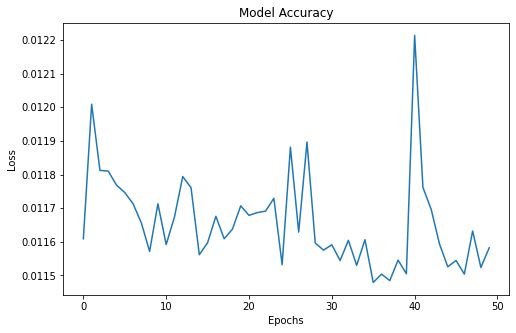

In [129]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Accuracy")

In [130]:
min_preds= model.predict(X_min_test)
min_preds = scaler.inverse_transform(min_preds)


Y_min_test=np.asanyarray(Y_min_test)  
Y_min_test=Y_min_test.reshape(-1,1) 
Y_min_test = scaler.inverse_transform(Y_min_test)


Y_min_train=np.asanyarray(Y_min_train)  
Y_min_train=Ytrain.reshape(-1,1) 
Y_min_train = scaler.inverse_transform(Y_min_train)

mean_squared_error(Y_min_test,preds)

2/2 [==============================] - 0s 29ms/step


0.89077634

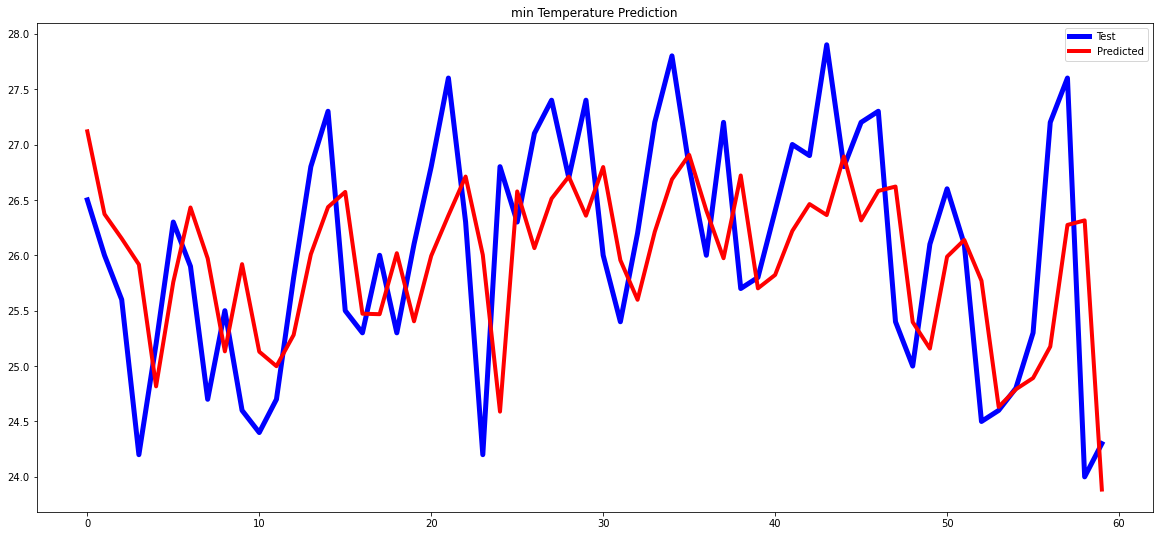

In [131]:
plt.figure(figsize=(20,9))
plt.plot(Y_min_test , 'blue', linewidth=5)
plt.plot(min_preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("min Temperature Prediction")
plt.show()


In [132]:
min_test = pd.DataFrame(Y_min_test,columns=['Actual'])
min_pred = pd.DataFrame(min_preds,columns=['Predict'])

In [133]:
min_results = pd.concat([min_test,min_pred],axis=1)

In [134]:
min_results.head(9)

,Actual,Predict
0,26.500000,27.118927
1,26.000000,26.371731
2,25.600000,26.151440
3,24.200001,25.916817
4,25.200001,24.817005
5,26.299999,25.758402
6,25.900000,26.431490
7,24.700001,25.971786
8,25.500000,25.132812


In [140]:
# this section for unknown future
#we are getting next 30 steps
from datetime import timedelta
future=60
min_forcast = []
Xin = X_min_test[-1:,:,:]
time=[]
for i in range(future):
    out = model.predict(Xin, batch_size=1)    
    min_forcast.append(out[0,0]) 
    print(min_forcast)
    Xin = insert_end(Xin,out[0,0]) 
    time.append(pd.to_datetime(temp_min_df.index[-1])+timedelta(days=i+1))

1/1 [==============================] - 0s 31ms/step
[0.07852701]
1/1 [==============================] - 0s 26ms/step
[0.07852701, 0.07156999]
1/1 [==============================] - 0s 29ms/step
[0.07852701, 0.07156999, 0.06531335]
1/1 [==============================] - 0s 29ms/step
[0.07852701, 0.07156999, 0.06531335, 0.059578717]
1/1 [==============================] - 0s 25ms/step
[0.07852701, 0.07156999, 0.06531335, 0.059578717, 0.054575033]
1/1 [==============================] - 0s 25ms/step
[0.07852701, 0.07156999, 0.06531335, 0.059578717, 0.054575033, 0.050159812]
1/1 [==============================] - 0s 26ms/step
[0.07852701, 0.07156999, 0.06531335, 0.059578717, 0.054575033, 0.050159812, 0.04603564]
1/1 [==============================] - 0s 27ms/step
[0.07852701, 0.07156999, 0.06531335, 0.059578717, 0.054575033, 0.050159812, 0.04603564, 0.041564785]
1/1 [==============================] - 0s 27ms/step
[0.07852701, 0.07156999, 0.06531335, 0.059578717, 0.054575033, 0.050159812, 0.0

In [141]:
min_forcasted_output=np.asanyarray(min_forcast)   
min_forcasted_output=min_forcasted_output.reshape(-1,1) 
min_forcasted_output = scaler.inverse_transform(min_forcasted_output) 

In [142]:
min_forcasted_output = pd.DataFrame(min_forcasted_output)
date = pd.DataFrame(time)
min_df_result = pd.concat([date,min_forcasted_output],axis=1)
min_df_result.columns = "Date","Forecasted"

In [143]:
min_df_result

,Date,Forecasted
0,2022-10-01,17.129745
1,2022-10-02,17.034088
2,2022-10-03,16.948059
3,2022-10-04,16.869207
4,2022-10-05,16.800407
5,2022-10-06,16.739697
6,2022-10-07,16.682991
7,2022-10-08,16.621517
8,2022-10-09,16.556116
9,2022-10-10,16.487461
